In [1]:
import numpy as np
from math import pi, sin, cos
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import DRT_Lib

## Example 1: ZARC circuit
### 1) Synthesize data:
The impedance of a ZARC can be written as
$$
Z^{\rm exact}(f) = R_\infty + \displaystyle \frac{1}{\displaystyle \frac{1}{R_{\rm ct}}+C \left(i 2\pi f\right)^\phi}
$$

where $\displaystyle C = \frac{\tau_0^\phi}{R_{\rm ct}}$.

The analytical DRT can be computed analytically as

$$
\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0))-\cos(\pi(1-\phi))}
$$

Random noise ($\sigma_n$) is added to impedance response.

In [3]:
# define the frequency range
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
tau  = 1/freq_vec

# parameters for ZARC model, the impedance and analytical DRT are calculated as the above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.

C = tau_0**phi/R_ct
Z_exact = R_inf+1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# we will use a finer mesh for plotting the results
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi)) # for plotting only

# we will add noise to the impedance computed analytically
rng = np.random.seed(214975)
sigma_n_exp = 0.1
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

### 2) Compute DRT:
#### a. Deep-Prior DRT:
Tunable hyperparameters:
* lambda_limit ($\lambda_{lim}$): criteria for early stopping: $\lambda_{lim}=\frac{|MSE_{n+1}-MSE_n|}{MSE_n}$. Default: $1e^{-4}$
* learning_rate: neural network learning rate. Default: $1e^{-5}$

Early stop. Number of iteration:  17471


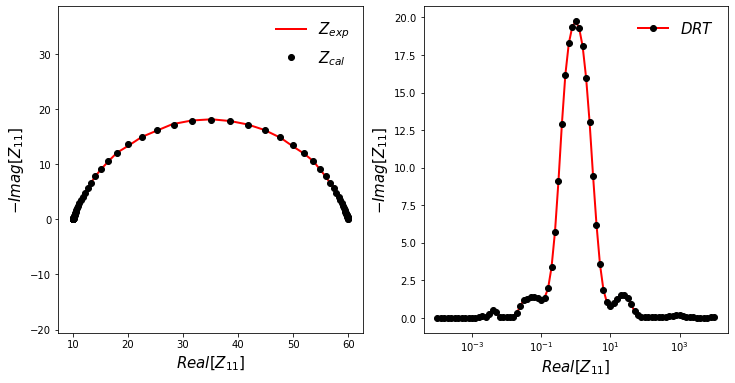

In [4]:
gamma1, R_inf1, loss1 = DRT_Lib.DP_DRT(freq_vec, Z_exp, display=True)

#### b. Gaussian Process DRT:
Tunable hyperparameters:
* sigma_n ($\sigma_n$): Standard deviation of experimental impedance noise. Default: $0.1$

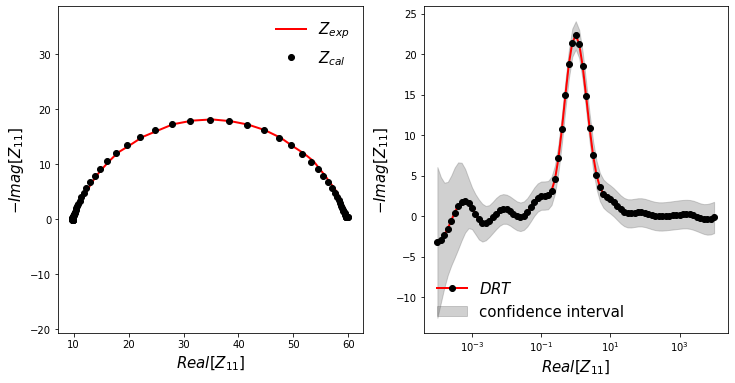

In [5]:
gamma2, R_inf2, sigma_gamma2 = DRT_Lib.GP_DRT(freq_vec, Z_exp, display=True)

#### c. Tikhonov Regularization:
Tunable hyperparameters:
* el ($\lambda$): Tikhonov regularization factor. Default: $1e^{-4}$
* method: Optimization method, select from "SLSQP", "L-BFGS-B", and "TNC". Default: "SLSQP"

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.077023079080526
            Iterations: 82
            Function evaluations: 6893
            Gradient evaluations: 82


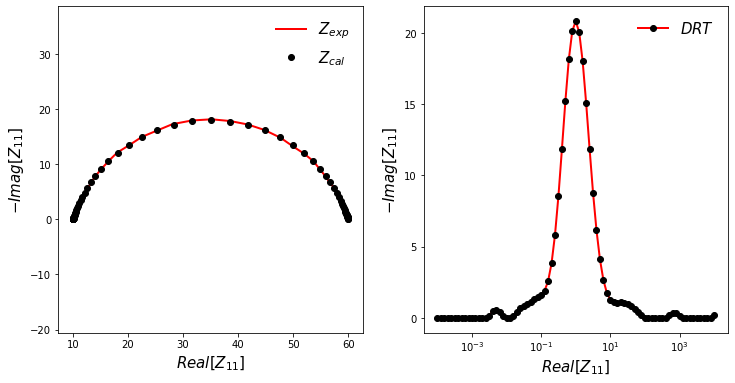

In [6]:
gamma3, R_inf3, loss3 = DRT_Lib.TR_DRT(freq_vec, Z_exp, el=1e-2, display=True)

### 3. Compare Results:

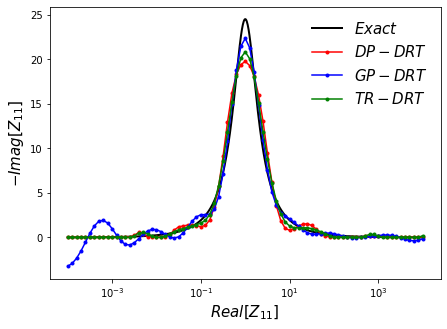

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
ax.semilogx(freq_vec_plot, gamma_fct_plot, color='black', linewidth=2, label="$Exact$")
ax.semilogx(freq_vec, gamma1, 'r.-', label="$DP-DRT$")
ax.semilogx(freq_vec, gamma2, 'b.-', label="$GP-DRT$")
ax.semilogx(freq_vec, gamma3, 'g.-',label="$TR-DRT$")
ax.legend(frameon=False, fontsize = 15)
ax.set_xlabel(r'$Real[Z_{11}]$', fontsize = 15)
ax.set_ylabel(r'$-Imag[Z_{11}]$', fontsize = 15)
plt.show()

## Example 2: Double ZARC circuit
### 1) Synthesize data:
The impedance has the format of 

$$
Z^{\rm exact}(f) = 2R_\infty + \displaystyle \frac{1}{\displaystyle \frac{1}{R_{\rm ct}}+C_1 \left(i 2\pi f\right)^{\phi}} + \displaystyle \frac{1}{\displaystyle\frac{1}{R_{\rm ct}}+C_2 \left(i 2\pi f\right)^{\phi}}
$$ 
where $\displaystyle C_1 = \frac{\tau_1^\phi}{R_{\rm ct}}$ and $\displaystyle C_2 = \frac{\tau_2^\phi}{R_{\rm ct}}$

In this tutorial, $\tau_1=0.1$ and $\tau_2=10$

The analytical DRT is calculated as 

$$
\gamma(\log \tau) = \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \sin\left((1-\phi)\pi\right) \displaystyle \left(\frac{1 }{\displaystyle \cosh(\phi \log(\tau/\tau_1))-\cos(\pi(1-\phi))} +  \displaystyle \frac{1}{\displaystyle \cosh(\phi \log(\tau/\tau_2))-\cos(\pi(1-\phi))}\right)
$$

Random noise ($\sigma_n$) is added to impedance response.

In [8]:
# define the frequency range
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for two ZARCs in series, the impedance, and the analytical DRT are calculated as the above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_1 = 0.1
tau_2 = 10

C_1 = tau_1**phi/R_ct
C_2 = tau_2**phi/R_ct

Z_exact = 2*R_inf + 1./(1./R_ct+C_1*(1j*2.*pi*freq_vec)**phi) + 1./(1./R_ct+C_2*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)*(1/(np.cosh(phi*np.log(tau/tau_1))-cos((1.-phi)*pi)) +\
                                             1/(np.cosh(phi*np.log(tau/tau_2))-cos((1.-phi)*pi)))

# used for plotting only
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)*(1/(np.cosh(phi*np.log(tau_plot/tau_1))-cos((1.-phi)*pi)) +\
                                                  1/(np.cosh(phi*np.log(tau_plot/tau_2))-cos((1.-phi)*pi)))
# adding random noise to the synthetic data
rng = np.random.seed(214975)
sigma_n_exp = 0.1
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

### 2) Compute DRT:
#### a. Deep-Prior DRT:
Tunable hyperparameters:
* lambda_limit ($\lambda_{lim}$): criteria for early stopping: $\lambda_{lim}=\frac{|MSE_{n+1}-MSE_n|}{MSE_n}$. Default: $1e^{-4}$
* learning_rate: neural network learning rate. Default: $1e^{-5}$

Early stop. Number of iteration:  17379


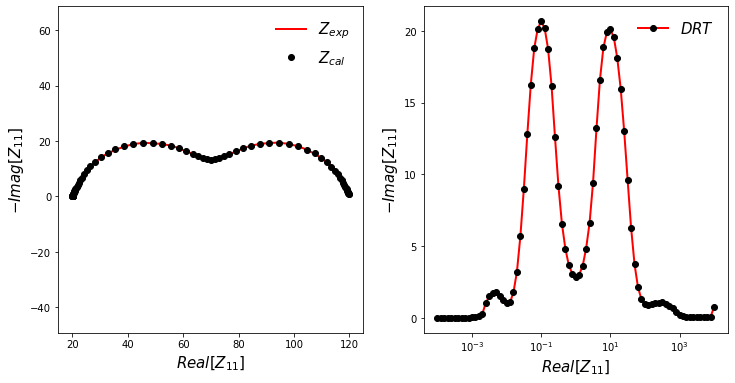

In [9]:
gamma1, R_inf1, loss1 = DRT_Lib.DP_DRT(freq_vec, Z_exp, display=True)

#### b. Gaussian Process DRT:
Tunable hyperparameters:
* sigma_n ($\sigma_n$): Standard deviation of experimental impedance noise. Default: $0.1$

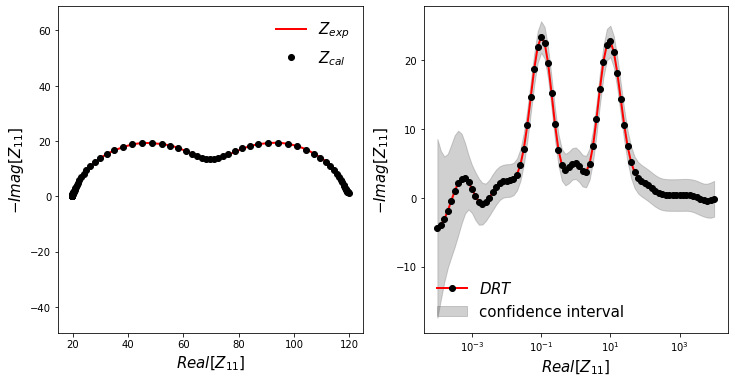

In [10]:
gamma2, R_inf2, sigma_gamma2 = DRT_Lib.GP_DRT(freq_vec, Z_exp, display=True)

#### c. Tikhonov Regularization:
Tunable hyperparameters:
* el ($\lambda$): Tikhonov regularization factor. Default: $1e^{-4}$
* method: Optimization method, select from "SLSQP", "L-BFGS-B", and "TNC". Default: "SLSQP"

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 32.338144988573795
            Iterations: 68
            Function evaluations: 5719
            Gradient evaluations: 68


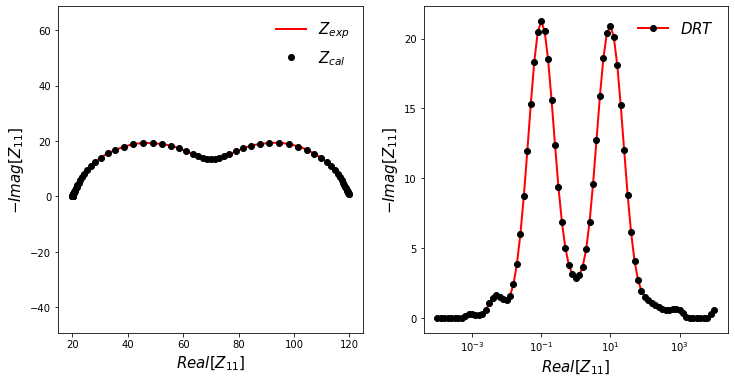

In [11]:
gamma3, R_inf3, loss3 = DRT_Lib.TR_DRT(freq_vec, Z_exp, el=1e-2, display=True)

### 3. Compare Results:

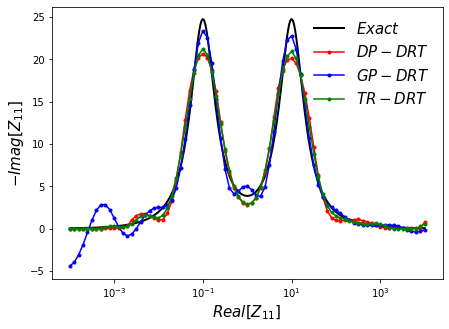

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
ax.semilogx(freq_vec_plot, gamma_fct_plot, color='black', linewidth=2, label="$Exact$")
ax.semilogx(freq_vec, gamma1, 'r.-', label="$DP-DRT$")
ax.semilogx(freq_vec, gamma2, 'b.-', label="$GP-DRT$")
ax.semilogx(freq_vec, gamma3, 'g.-',label="$TR-DRT$")
ax.legend(frameon=False, fontsize = 15)
ax.set_xlabel(r'$Real[Z_{11}]$', fontsize = 15)
ax.set_ylabel(r'$-Imag[Z_{11}]$', fontsize = 15)
plt.show()